<a href="https://colab.research.google.com/github/PrinceMayur007/Neural-Networks/blob/main/RNN_clothing_sales_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# RNN Example for Clothing Sales Data

In [ ]:
import pandas as pd
import numpy as np
import io

%matplotlib inline
import matplotlib.pyplot as plt

## Data

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving RSCCASN.csv to RSCCASN.csv


In [ ]:
df = pd.read_csv('RSCCASN.csv',index_col='DATE',parse_dates=True)

In [ ]:
df

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [ ]:
df.columns = ['Sales']

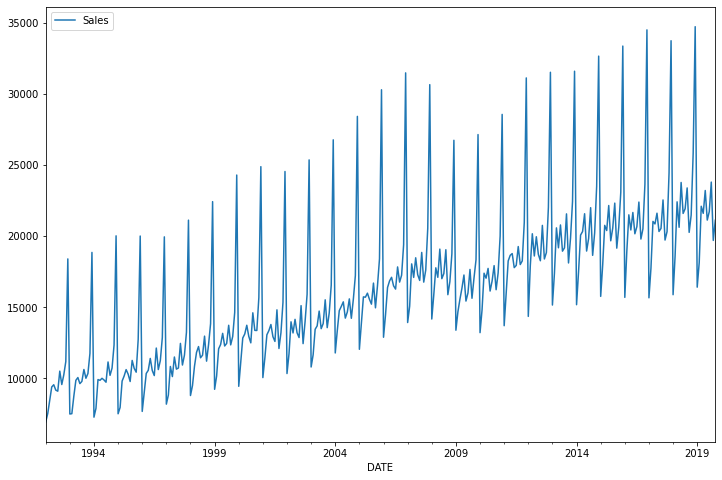

In [ ]:
df.plot(figsize=(12,8))

## Train Test Split

In [ ]:
len(df)

334

Data is monthly, let's forecast 1.5 years into the future.

In [ ]:
len(df)- 18

316

In [ ]:
test_size = 18

In [ ]:
test_ind = len(df)- test_size

In [ ]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [ ]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [ ]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


## Scale Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAINING DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [ ]:
scaled_train[:20]

array([[0.        ],
       [0.02127505],
       [0.05580163],
       [0.08942056],
       [0.09512053],
       [0.08146965],
       [0.07860151],
       [0.12979233],
       [0.09566512],
       [0.1203892 ],
       [0.15426227],
       [0.41595266],
       [0.02047633],
       [0.02127505],
       [0.06636654],
       [0.10633895],
       [0.11345484],
       [0.09791606],
       [0.10368864],
       [0.13396747]])

In [ ]:
# What does the first batch look like?
X,y = generator[1]

In [ ]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.02127505 0.05580163 0.08942056 0.09512053 0.08146965 0.07860151
 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266 0.02047633]
Predict this y: 
 [[0.02127505]]


## Create the Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN

In [ ]:
# We're only using one feature in our time series
n_features = 1

In [ ]:
# define model
model = Sequential()
model.add(SimpleRNN(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 100)               10200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


## EarlyStopping and creating a Validation Generator
 
NOTE: The scaled_test dataset size MUST be greater than your length chosen for your batches.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [ ]:
# fit model
model.fit(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 3s 5ms/step - loss: 0.0240 - val_loss: 0.0053
Epoch 2/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 3/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0127 - val_loss: 6.5448e-04
Epoch 4/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 5/20
304/304 [==============================] - 1s 3ms/step - loss: 9.1361e-04 - val_loss: 8.0276e-04


In [ ]:
losses = pd.DataFrame(model.history.history)

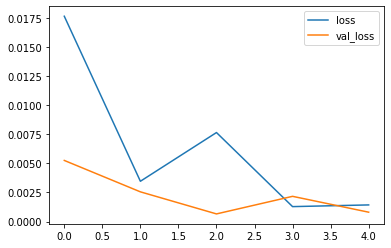

In [ ]:
losses.plot()

## Evaluate on Test Data

In [ ]:
first_eval_batch = scaled_train[-length:]

In [ ]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

In [ ]:
model.predict(first_eval_batch)

array([[0.56147164]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.61087714])

Now let's put this logic in a for loop to predict into the future for the entire test range.

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Inverse Transformations and Compare

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22403.174881
2018-06-01,21589,20478.353953
2018-07-01,21919,21501.461569
2018-08-01,23381,23453.918081
2018-09-01,20260,20371.301980
2018-10-01,21473,21882.920618
2018-11-01,25831,24639.673903
2018-12-01,34706,31912.729678
2019-01-01,16410,18361.320179


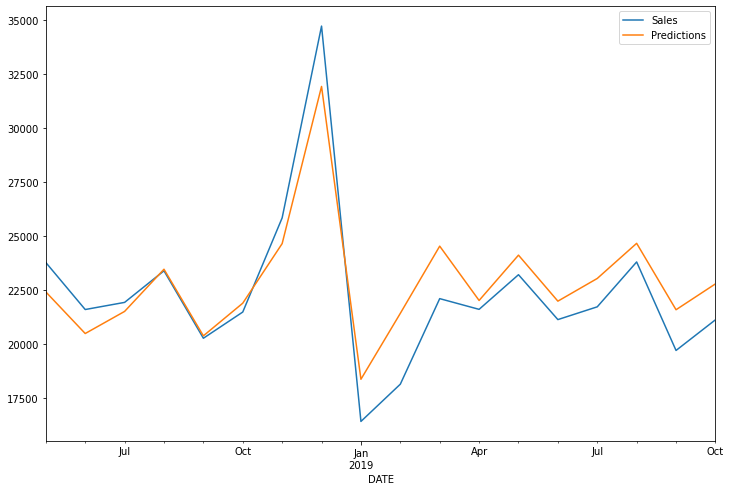

In [ ]:
test.plot(figsize=(12,8))

##Retrain using LSTM

LSTM's are a better version of RNN's which have a longer short term memory


In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
n_features = 1

LSTM_model = Sequential()
LSTM_model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
LSTM_model.add(Dense(1))
LSTM_model.compile(optimizer='adam', loss='mse')

LSTM_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
LSTM_model.fit(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 3s 6ms/step - loss: 0.0422 - val_loss: 0.0027
Epoch 2/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0175 - val_loss: 0.0046
Epoch 3/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0125 - val_loss: 0.0021
Epoch 4/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0053 - val_loss: 0.0140
Epoch 5/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0042 - val_loss: 0.0029


In [ ]:
lstm_test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = LSTM_model.predict(current_batch)[0]
    
    # store prediction
    lstm_test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
lstm_true_predictions = scaler.inverse_transform(lstm_test_predictions)

In [ ]:
test['LSTM'] = lstm_true_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


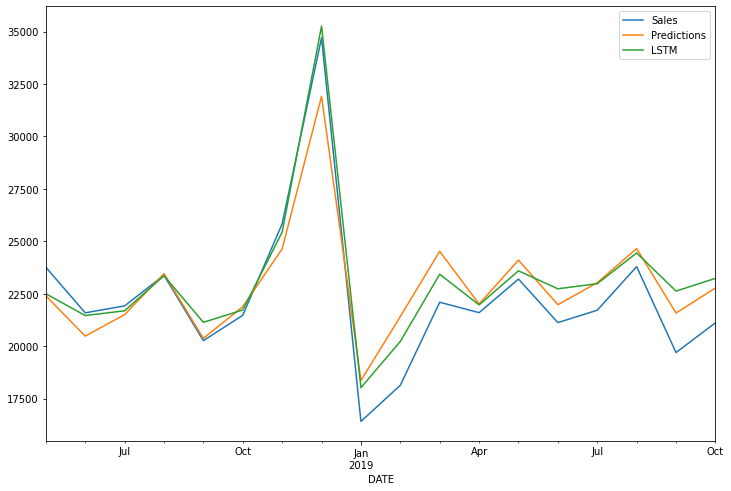

In [ ]:
test.plot(figsize=(12,8))

## Retrain and Forecasting

In [ ]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [ ]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit(generator,epochs=8)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
322/322 [==============================] - 3s 5ms/step - loss: 0.0340
Epoch 2/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0173
Epoch 3/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0125
Epoch 4/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0057
Epoch 5/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0028
Epoch 6/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0017
Epoch 7/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0028
Epoch 8/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0011


In [ ]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
forecast = scaler.inverse_transform(forecast)

## Creating new timestamp index with pandas.

In [ ]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [ ]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [ ]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [ ]:
forecast_df

,Forecast
2019-11-01,25126.413475
2019-12-01,34876.946028
2020-01-01,16206.329136
2020-02-01,17676.452534
2020-03-01,20917.991708
2020-04-01,20583.742011
2020-05-01,22072.656062
2020-06-01,20331.915569
2020-07-01,20885.696837
2020-08-01,22772.819895


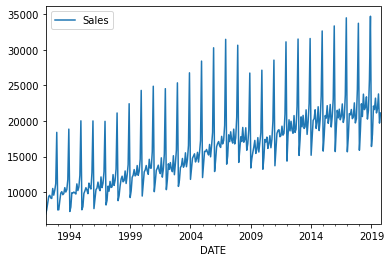

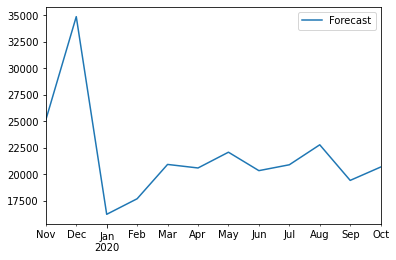

In [ ]:
df.plot()
forecast_df.plot()

## Joining pandas plots

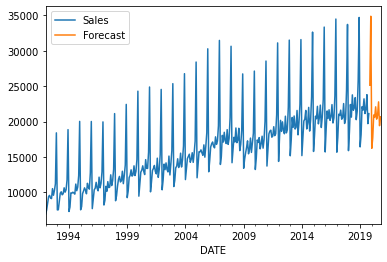

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

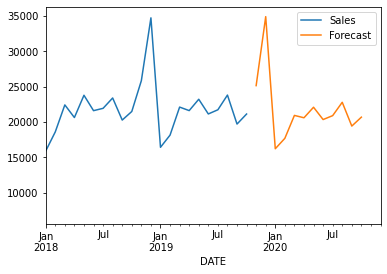

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')